<a href="https://colab.research.google.com/github/eliza-giane/acdc-dl-project/blob/main/ACDC_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

**This is the Automated Cardiac Disease Challenge (ACDC) Project for Deep Learning at AIT by Eliza Giane, Shirui Li, and Lydia Yang.**


This project was prompted by the challenge (found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/index.html)). The data consists of real anonymized and regulated clinical exams from the University Hospital of Dijon, and is described as follows on the challenge's website:

---
"Our dataset covers several well-defined pathologies with enough cases to (1) properly train machine learning methods and (2) clearly assess the variations of the main physiological parameters obtained from cine-MRI (in particular diastolic volume and ejection fraction)."

"The dataset is composed of 150 exams (all from different patients) divided into 5 evenly distributed subgroups (4 pathological plus 1 healthy subject groups)...Furthermore, each patient comes with the following additional information : weight, height, as well as the diastolic and systolic phase instants."

---
 The dataset to be downloaded is found [here](https://humanheart-project.creatis.insa-lyon.fr/database/#collection/637218c173e9f0047faa00fb/folder/637218e573e9f0047faa00fc).

  <!-- and the provided code for handling .nii files is found [here](https://www.creatis.insa-lyon.fr/Challenge/acdc/code/metrics_acdc.py). -->

\\
**Any use of the ACDC database requires the following citation:**

O. Bernard, A. Lalande, C. Zotti, F. Cervenansky, et al.
"Deep Learning Techniques for Automatic MRI Cardiac Multi-structures Segmentation and Diagnosis: Is the Problem Solved ?" in IEEE Transactions on Medical Imaging, vol. 37, no. 11, pp. 2514-2525, Nov. 2018, doi: 10.1109/TMI.2018.2837502

Running the code:

Please download and move the dataset to your Google Drive under MyDrive and rename the folder "ACDC-Challenge" to run the code as is. Otherwise, change the variable dataDir in the below code cell to your local folder.

In [ ]:
import nibabel as nib
import numpy as np
import tensorflow as tf
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import configparser
import cv2
from configparser import ConfigParser
from skimage import io
from pathlib import Path
from PIL import Image

from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation, Conv1D, MaxPooling1D
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score

from google.colab import drive
drive.mount('/content/drive')
dataDir = '/content/drive/MyDrive/ACDC-Challenge/database/'

Mounted at /content/drive


In [ ]:
def patientNames(trainingOrTesting):
  '''
  Returns a list of patient file names
  trainingOrTesting = "training" or "testing"
  '''
  if trainingOrTesting == 'training':
    L = []
    for i in range(1, 101):
        if i < 10:
            patient = "patient" + "00" + str(i)
        elif 10 <= i <= 99:
            patient = "patient" + "0" + str(i)
        else:
            patient = "patient" + str(i)
        L.append(patient)
    return L
  elif trainingOrTesting == 'testing':
     return [("patient" + str(i)) for i in range(101, 151)]

NOTE: If you are working with the a freshly downloaded dataset, please uncomment and run the following cell. It only needs to be run once to add the converted jpeg files into the dataset.

In [ ]:
# # Source: https://stackoverflow.com/questions/68691070/how-to-handle-image-with-extension-nii-gz-is-it-possible-to-convert-them-in-gr
# def to_uint8(data):
#     data -= data.min()
#     data /= data.max()
#     data *= 255
#     return data.astype(np.uint8)

# def nii_to_jpgs(input_path, output_dir, rgb=False):
#     output_dir = Path(output_dir)
#     data = nib.load(input_path).get_fdata()
#     *_, num_slices, num_channels = data.shape
#     for channel in range(num_channels):
#         volume = data[..., channel]
#         volume = to_uint8(volume)
#         channel_dir = output_dir / f'channel_{channel}'
#         channel_dir.mkdir(exist_ok=True, parents=True)
#         for slice in range(num_slices):
#             slice_data = volume[..., slice]
#             if rgb:
#                 slice_data = np.stack(3 * [slice_data], axis=2)
#             output_path = channel_dir / f'channel_{channel}_slice_{slice}.jpg'
#             io.imsave(output_path, slice_data)

# # This is written to convert all images to jpegs in the directory
# def convertToJPGs():
#   for typ in ["training", "testing"]:
#     for patient in patientNames(typ):
#         input_path = dataDir + d_type + "/" + patient + "/" + patient + "_4d.nii.gz"
#         output_dir = dataDir + d_type + "/" + patient
#         nii_to_jpgs(input_path, output_dir, rgb=False) #converts nii to jpgs

# convertToJPGs()

# **Acquiring Data**

The data is stored in Google Drive for access. We organize data into useful forms for pre-processing.

In [ ]:
label_nums = {'NOR': 0, 'DCM': 1, 'HCM': 2, 'MINF': 3, 'RV': 4}

def labelAll(d_type, start, end):
    '''
    Creates dictionary of labels for patient groups
    d_type = "training" or "testing"
    amt = number of patients to be added to the list (if -1, add all)
    '''
    # Get the list of patient names
    patientName = patientNames(d_type)
    patientList = []  # List to store labels for patient groups

    # Iterate through each patient's data
    for patient in range(start,end):
    # for patient in patientName:
        # Construct the path to the Info.cfg file
        infopath = dataDir + d_type + "/" + patientName[patient] + "/Info.cfg"

        # Read the Info.cfg file using ConfigParser
        parser = configparser.ConfigParser()
        with open(infopath) as stream:
            parser.read_string("[top]\n" + stream.read())

        # Extract group information from the Info.cfg file
        details_dict = dict(parser.items("top"))

        # Append the label for the patient's group to the patientList
        patientList.append(label_nums[details_dict['group']])

    # Converts patientList to array
    patientList = np.array(patientList)

    # Return the list of patient group labels
    return patientList

def labelSpecific(d_type, patientNames):
    '''
    Labels one patient
    d_type = "training" or "testing"
    amt = number of patients to be added to the list (if -1, add all)
    '''
    patientList = []  # List to store labels for patient groups

    for patient in patientNames: # for patient in patientName:
        # Construct the path to the Info.cfg file
        infopath = dataDir + d_type + "/" + patient + "/Info.cfg"

        # Read the Info.cfg file using ConfigParser
        parser = configparser.ConfigParser()
        with open(infopath) as stream:
            parser.read_string("[top]\n" + stream.read())

        # Extract group information from the Info.cfg file
        details_dict = dict(parser.items("top"))

        # Append the label for the patient's group to the patientList
        patientList.append(label_nums[details_dict['group']])

    # Converts patientList to array
    patientList = np.array(patientList)

    # Return the list of patient group labels
    return patientList

def getImages(dtype, patient, n, all):
  '''
  Retrieves a list of image paths for a given list of patient.

  Args:
  dtype (str): The type of data ("training" or "testing").
  patient (str): The patient's folder name.
  n (int): The number of slices to extract from each channel.
  all (bool): Whether to retrieve all slices (True) or a subset (False).

  Returns:
  list: A list of image paths if 'all' is True.
  tuple: A tuple containing a list of selected image paths and their count if 'all' is False.
  '''

  def unique(list1):
    '''
    Helper function to return a list of unique elements.
    '''
    list_set = set(list1)  # Convert the list to a set to remove duplicates.
    unique_list = list(list_set)  # Convert the set back to a list.
    return unique_list

  # Construct the path to the patient's data directory.
  output = dataDir + dtype + "/" + patient

  # List all directories in the output path that contain 'channel' in their name.
  channelNames = [x for x in os.listdir(output) if 'channel' in x]

  # Initialize lists to store image paths.
  imageList = []  # List to store the selected image paths.
  allList = []  # List to store all image paths if 'all' is True.

  # Iterate over each channel directory.
  for name in channelNames:
    # Get unique image names from the channel directory, excluding files with '(' in their name.
    imageNames = unique([x for x in os.listdir(output + "/" + name) if '(' not in x])

    # Create an ordered list of image paths.
    orderedList = [output + '/' + name + '/' + name + '_slice_' + str(x) + '.jpg' for x in range(len(imageNames))]

    # If 'all' is True, add all image paths to allList and continue to the next channel.
    if all:
      allList += orderedList
      continue

    # Calculate the midpoint of the image list.
    halfL = len(imageNames) // 2

    # Calculate half of the desired number of slices.
    halfN = n // 2

    # If there are fewer images than the desired number, add all images.
    if halfL < n:
      imageList += orderedList
    else:
      # Otherwise, add the central n images.
      imageList += orderedList[(halfL - halfN):(halfL + halfN + (n % 2))]

  # If 'all' is True, return all image paths.
  if all:
    return allList

  # Print the patient name and the number of images selected.
  print(patient, len(imageList))

  # Return the list of selected image paths and their count.
  return imageList, len(imageList)


def getData(d_type, patientList, n):
  '''
  Gets numpy array of 10 slices jpgs for each patient in the set
  '''
  shapesList = []  # List to store shapes of slice arrays
  dataList = []  # List to store slice arrays

  labeledSet = labelSpecific(d_type, patientList)
  newLabeledSet = []
  # Iterate through patients in the specified range
  for patient in range(len(patientList)):
      # Construct the path to the first slice jpg for the current patient

      slices, numberOfSlices = getImages(d_type, patientList[patient], n, False)
      newLabeledSet += [labeledSet[patient]]*numberOfSlices
      print(patient, patientList[patient])
      print(numberOfSlices, len(newLabeledSet))

      for s in slices:
        # Open the image using PIL
        with Image.open(s) as img:
            img.load()
            # Convert the image to a numpy array and append it to dataList
            image = np.array([img])
            dataList.append(image)
            # Append the shape of the image array to shapesList
            shapesList.append(image.shape)

  # Return the list of slice arrays and shapes
  return dataList, shapesList, newLabeledSet

# **Pre-Processing Data**

In [ ]:
# Divide the patient names in original training set into a training set and a valid set
x_train, x_valid = train_test_split(patientNames("training"), test_size=0.2, random_state=42, shuffle=True)

In [ ]:
# Shuffle two lists together with same indices
# Source: https://www.geeksforgeeks.org/python-shuffle-two-lists-with-same-order/
import random
def shuffleTwo(list1, list2):
  zipped = list(zip(list1, list2))
  random.shuffle(zipped)
  return zip(*zipped)

In [ ]:
# Get the image data of each set
x_train, train_shapes, y_train = getData('training', x_train, 1)
# Randomize the data within each set
x_train, y_train = shuffleTwo(x_train, y_train)

x_valid, valid_shapes, y_valid = getData('training', x_valid, 1)
x_valid, y_valid = shuffleTwo(x_valid, y_valid)

x_test, test_shapes, y_test = getData('testing', patientNames('testing'), 1)
x_test, y_test = shuffleTwo(x_test, y_test)

patient056 30
0 patient056
30 30
patient089 30
1 patient089
30 60
patient027 30
2 patient027
30 90
patient043 13
3 patient043
13 103
patient070 28
4 patient070
28 131
patient016 30
5 patient016
30 161
patient041 17
6 patient041
17 178
patient097 30
7 patient097
30 208
patient010 28
8 patient010
28 236
patient073 35
9 patient073
35 271
patient012 30
10 patient012
30 301
patient048 28
11 patient048
28 329
patient086 19
12 patient086
19 348
patient029 30
13 patient029
30 378
patient094 14
14 patient094
14 392
patient006 28
15 patient006
28 420
patient067 30
16 patient067
30 450
patient066 30
17 patient066
30 480
patient036 35
18 patient036
35 515
patient017 19
19 patient017
19 534
patient050 30
20 patient050
30 564
patient035 28
21 patient035
28 592
patient008 28
22 patient008
28 620
patient096 15
23 patient096
15 635
patient028 28
24 patient028
28 663
patient020 20
25 patient020
20 683
patient082 17
26 patient082
17 700
patient026 28
27 patient026
28 728
patient063 35
28 patient063
35 76

In [ ]:
from collections import Counter
Counter(y_train)

Counter({4: 387, 1: 386, 2: 437, 3: 460, 0: 466})

In [ ]:
Counter(y_test)

Counter({1: 237, 2: 290, 3: 285, 0: 265, 4: 197})

In [ ]:
# Resizing images to standard dimensions
def resize(L, x, y):
  output = []
  for i in range(len(L)):
    resized = cv2.resize(L[i][0], (x, y))
    output.append(resized)
  return np.array(output)

x_train = resize(x_train, 154, 154)
x_valid = resize(x_valid, 154, 154)
x_test = resize(x_test, 154, 154)

In [ ]:
x_train.shape

(2136, 154, 154)

In [ ]:
x_valid.shape

(562, 154, 154)

In [ ]:
x_test.shape

(1274, 154, 154)

In [ ]:
mean = x_train.mean(axis=0)
std  = x_train.std(axis=0)
x_train = (x_train-mean)/std
x_valid = (x_valid-mean)/std
x_test  = (x_test-mean)/std

In [ ]:
nb_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, nb_classes)
y_valid = to_categorical(y_valid, nb_classes)
y_test  = to_categorical(y_test, nb_classes)

# **Training the Model**

In [ ]:
x_train.shape

(2136, 154, 154)

In [ ]:
y_train.shape

(2136, 5)

In [ ]:
# Early Stopping Method
es = EarlyStopping(patience = 5, monitor = 'val_accuracy', restore_best_weights=True)
rate = 0.2

In [ ]:
nb_filter       = 3   # number of filter/kernels in the convolutional layers
filter_length   = 5  # length of the filter/kernel in the convolutional layers
window_size     = x_train.shape[1] # the window size defined by the dataset
nb_features     = x_train.shape[1] # the number of features of the input data (number of dimensions)
nb_outputs      = y_train.shape[1] # the number of outputs (defined by the target data)

In [ ]:
model = Sequential()

# First convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal', input_shape=(window_size, nb_features)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2, padding="valid"))
model.add(Dropout(rate))

# Second convolutional block
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Third convolutional block (additional layer)
model.add(Conv1D(filters=nb_filter*3, kernel_size=filter_length, activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(rate))

# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(rate))
model.add(Dense(nb_outputs, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
network_history = model.fit(x_train, y_train,
                            validation_data=(x_valid,y_valid),
                            batch_size=32,
                            epochs=100,
                            verbose=1,
                            callbacks=[es])

Epoch 1/100
67/67 [==============================] - 4s 15ms/step - loss: 1.3901 - accuracy: 0.4335 - val_loss: 2.2516 - val_accuracy: 0.3167
Epoch 2/100
67/67 [==============================] - 1s 9ms/step - loss: 0.7519 - accuracy: 0.7210 - val_loss: 2.5354 - val_accuracy: 0.3416
Epoch 3/100
67/67 [==============================] - 1s 9ms/step - loss: 0.4239 - accuracy: 0.8596 - val_loss: 2.6860 - val_accuracy: 0.3310
Epoch 4/100
67/67 [==============================] - 1s 10ms/step - loss: 0.2315 - accuracy: 0.9316 - val_loss: 2.6636 - val_accuracy: 0.3577
Epoch 5/100
67/67 [==============================] - 1s 9ms/step - loss: 0.1560 - accuracy: 0.9555 - val_loss: 3.3887 - val_accuracy: 0.3256
Epoch 6/100
67/67 [==============================] - 1s 10ms/step - loss: 0.1394 - accuracy: 0.9551 - val_loss: 3.4385 - val_accuracy: 0.3025
Epoch 7/100
67/67 [==============================] - 1s 9ms/step - loss: 0.0962 - accuracy: 0.9714 - val_loss: 3.7648 - val_accuracy: 0.3078
Epoch 8/10

# **Evaluation of Model**



In [ ]:
eval = model.evaluate(x_test,y_test)
print("Test loss:",eval[0])
print("Test accuracy:",eval[1])

40/40 [==============================] - 0s 4ms/step - loss: 1.9405 - accuracy: 0.3948
Test loss: 1.94050133228302
Test accuracy: 0.3948194682598114


In [ ]:
preds = model.predict(x_test)

40/40 [==============================] - 0s 3ms/step


In [ ]:
print(classification_report(np.argmax(y_test,1),np.argmax(preds,1)))

              precision    recall  f1-score   support

           0       0.36      0.37      0.37       265
           1       0.41      0.41      0.41       237
           2       0.48      0.20      0.28       290
           3       0.42      0.59      0.49       285
           4       0.34      0.42      0.37       197

    accuracy                           0.39      1274
   macro avg       0.40      0.40      0.38      1274
weighted avg       0.41      0.39      0.38      1274



In [ ]:
balanced_accuracy_score(np.argmax(y_test,1),np.argmax(preds,1))

0.397287845295886

<Axes: >

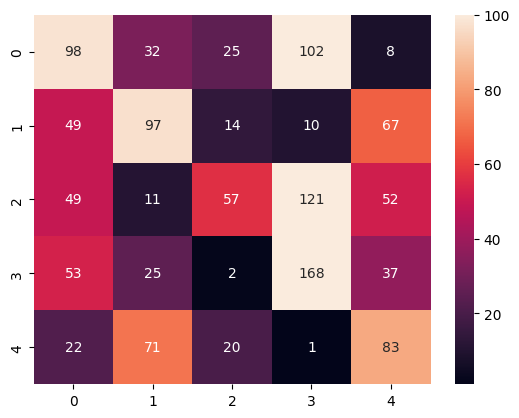

In [ ]:
conf=confusion_matrix(np.argmax(y_test,1),np.argmax(preds,1))
sns.heatmap(conf, annot=True, fmt='d', vmax=100)